# City initialization and methods

In [1]:
import os
import pandas as pd
import geopandas as gpd

example_data_path = "data"

## Initialization

Use the results obtained from the ``blocksnet.preprocessing`` or use your own data.

In [2]:
blocks = gpd.read_parquet(os.path.join(example_data_path, "blocks.parquet"))
adj_mx = pd.read_pickle(os.path.join(example_data_path, "adj_mx.pickle"))

In [3]:
from blocksnet.models import City

city = City(
  blocks=blocks, 
  adj_mx=adj_mx, 
) 

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Print city model to get the information about existing service types, CRS and blocks count

In [4]:
print(city)

CRS : EPSG:32636
Blocks : 16320
Service types : 66
Buildings : 0
Services : 0



## Update layers

Update the information about services and buildings using ``.update_buildings()`` and ``.update_services()``.

It is **IMPORTANT** to update buildings first, because they serve as container for some kinds of services.

Specification for buildings is described in the ``blocksnet.models.city.Building``

In [5]:
buildings = gpd.read_parquet(os.path.join(example_data_path, "platform/buildings.parquet")).to_crs(city.crs)

In [6]:
buildings = buildings.rename(columns={
  'population_balanced': 'population',
  'building_area': 'footprint_area',
})
buildings = buildings.fillna(0)
buildings['number_of_floors'] = buildings.apply(
  lambda x : x['storeys_count'] if x['storeys_count']>1 else 1, 
  axis=1
)
buildings['build_floor_area'] = buildings['footprint_area']*buildings['number_of_floors']
buildings['business_area'] = buildings['build_floor_area'] - buildings['living_area']

In [7]:
bad_buildings = city.update_buildings(buildings)

2024-07-18 17:16:00.065 | INFO     | blocksnet.models.city:update_buildings:1225 - Removing existing blocks from the model


2024-07-18 17:16:00.094 | INFO     | blocksnet.models.city:update_buildings:1229 - Joining buildings and blocks
2024-07-18 17:16:18.779 | WARNING  | blocksnet.models.city:update_buildings:1241 - 1721 buildings did not intersect any block
Update blocks buildings: 100%|██████████| 6109/6109 [00:28<00:00, 214.80it/s]


Visualize buildings that did not intersect any block

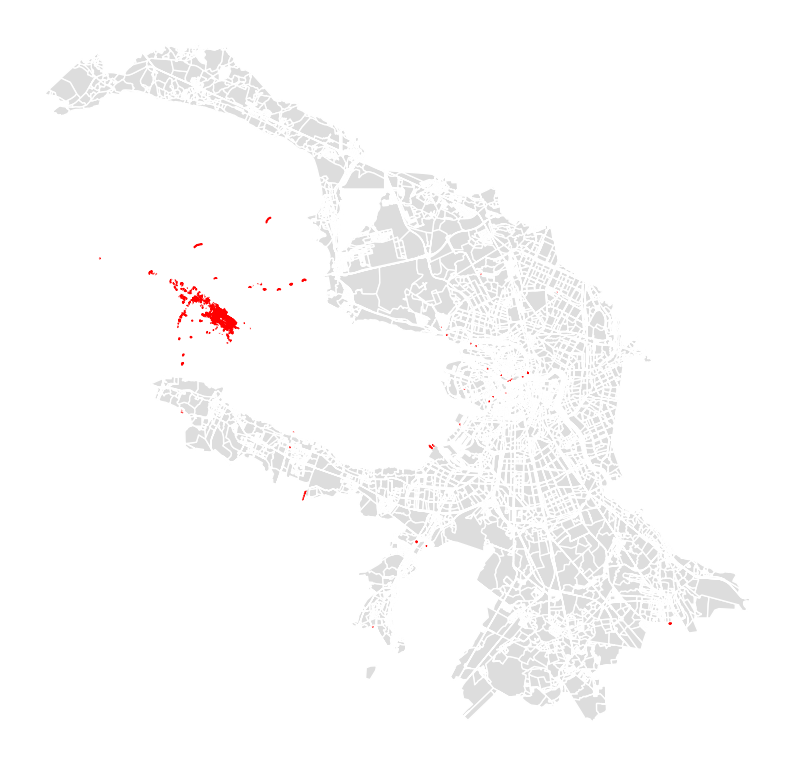

In [19]:
ax = blocks.plot(color='#ddd', figsize=(10,10))
bad_buildings.plot(linewidth=1, edgecolor='red', color='red', ax=ax).set_axis_off()

Visualize the model using ``.plot()`` method. If you don't have ``LandUse`` in your blocks, you can update the info later via ``.update_land_use()`` method.

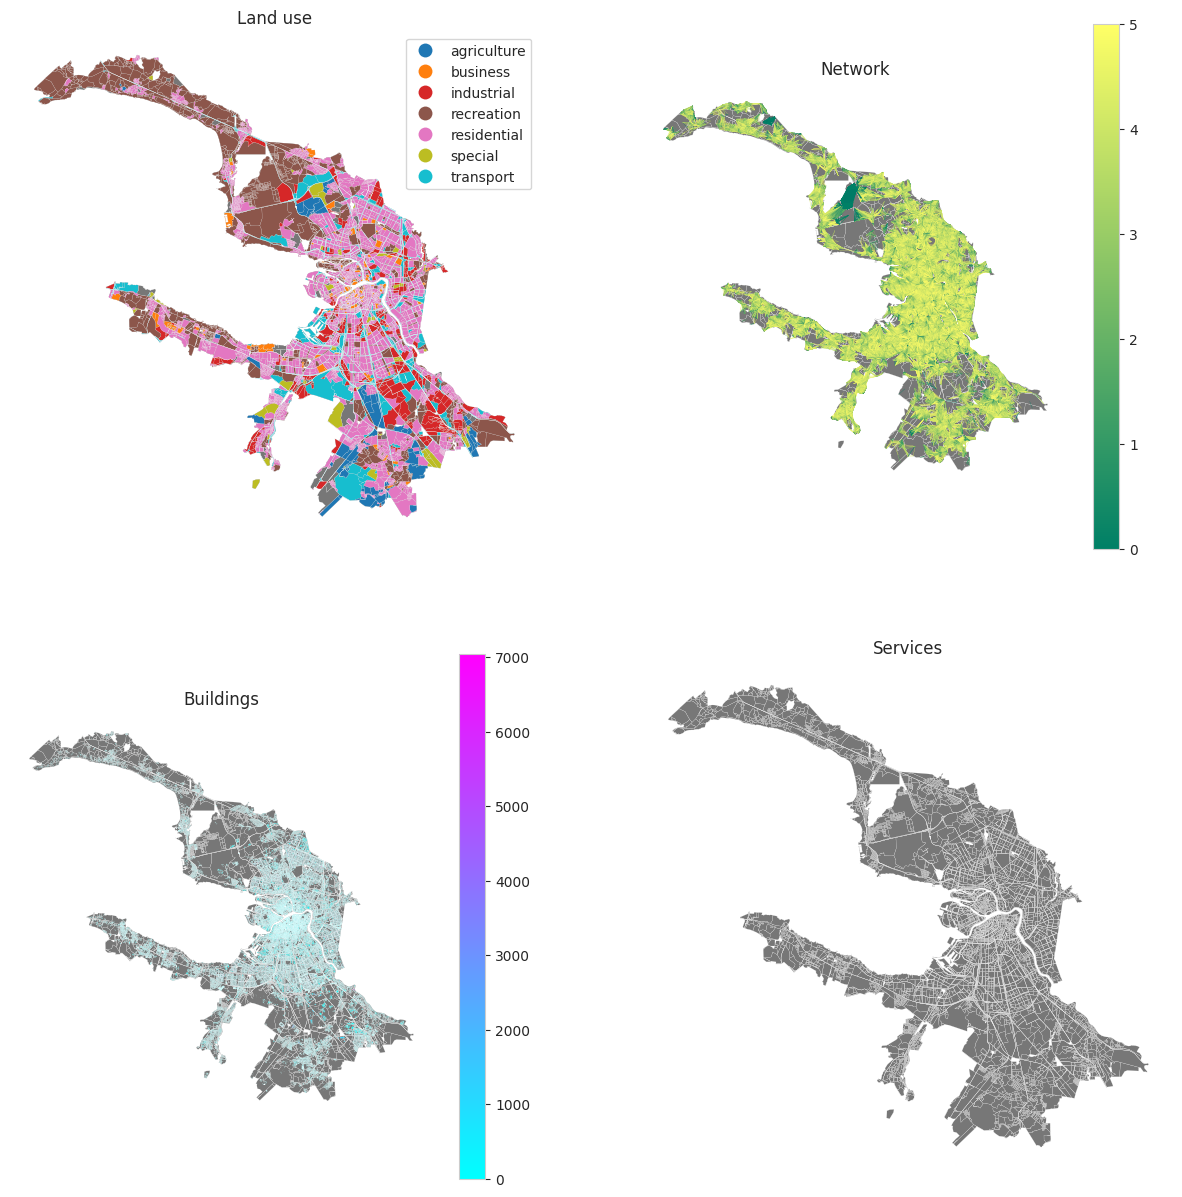

In [22]:
city.plot(max_travel_time=5)

Specification is described in the ``blocksnet.models.city.Service``

In [27]:
from tqdm import tqdm

for service_type in tqdm(city.service_types):
  try:
    services_gdf = gpd.read_parquet(os.path.join(example_data_path, f"platform/{service_type.name}.parquet"))
    city.update_services(service_type, services_gdf.to_crs(city.crs))
  except:
    ...

100%|██████████| 66/66 [01:15<00:00,  1.15s/it]


## Methods and other ways to operate the ``City`` model

Save city model to file with ``.to_pickle()`` so we can use it later

In [30]:
city.to_pickle(os.path.join(example_data_path, 'model.pickle'))

``Block`` within the city model can be obtained via ``id`` (int)

In [ ]:
block = city[123]
block

Block(id=123, geometry=<POLYGON ((346460.223 6649125.497, 346465.461 6649128.123, 346465.462 664912...>, land_use=<LandUse.MIXED_USE: 'mixed_use'>, buildings=None, services={}, city=<blocksnet.models.city.City object at 0x7f12698ac670>)

Get indicators for the block.

In [32]:
res = block.to_dict()
for key,value in res.items():
  if isinstance(value, float) : res[key]=round(res[key],2)
res

{'id': 2,
 'geometry': <POLYGON ((353934.329 6625429.433, 353923.453 6625429.324, 353918.105 662542...>,
 'land_use': 'recreation',
 'is_living': True,
 'build_floor_area': 1173.87,
 'living_demand': 58.69,
 'living_area': 821.71,
 'share_living': 0.71,
 'business_area': 352.16,
 'share_business': 0.3,
 'site_area': 363005.82,
 'population': 14,
 'footprint_area': 1163.48,
 'fsi': 0.0,
 'gsi': 0.0,
 'l': 1.01,
 'osr': 308.25,
 'mxi': 0.7,
 'capacity_fuel': 501}

Get available ``ServiceType``s for current ``Block`` ``LandUse``

In [33]:
available_service_types = block.land_use_service_types
[st.name for st in available_service_types]

['pitch',
 'swimming_pool',
 'stadium',
 'theatre',
 'museum',
 'cinema',
 'bowling_alley',
 'university',
 'beach',
 'train_building',
 'subway_entrance',
 'multifunctional_center',
 'park',
 'hotel',
 'circus',
 'post',
 'police',
 'dog_park',
 'hostel',
 'guest_house',
 'reserve',
 'sanatorium',
 'embankment',
 'wastewater_plant',
 'water_works',
 'substation',
 'train_station',
 'bus_station',
 'bus_stop',
 'pier']

``ServiceType`` can be obtained the same way by ``name`` (str). The information about accessibility, demand, bricks can be obtained this way.

In [34]:
service_type = city['school']
service_type

ServiceType(code='3.5.1', name='school', accessibility=15, demand=120, land_use=[<LandUse.RESIDENTIAL: 'residential'>, <LandUse.BUSINESS: 'business'>], bricks=[ServiceBrick(capacity=250, area=3200.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=300, area=4000.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=600, area=8200.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=1100, area=13000.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=250, area=2200.0, is_integrated=True, parking_area=200.0), ServiceBrick(capacity=300, area=3600.0, is_integrated=True, parking_area=300.0), ServiceBrick(capacity=600, area=7100.0, is_integrated=True, parking_area=600.0)])

Add new ``ServiceType`` to the ``City`` model list

In [35]:
from blocksnet import ServiceType

city.add_service_type(ServiceType(code='', name='internet_cafe', accessibility=30, demand=100, bricks=[]))
city['internet_cafe']

ServiceType(code='', name='internet_cafe', accessibility=30, demand=100, land_use=[], bricks=[])

Get the distance (min) between two city ``Block``s

In [36]:
city.get_distance(0, 1)

7.4

Get blocks ``GeoDataFrame`` via ``.get_blocks_gdf()`` method. Use ``simplify=True`` to exclude information about services.

In [37]:
blocks_gdf = city.get_blocks_gdf(simplify=True)
blocks_gdf.head()

,geometry,land_use,is_living,build_floor_area,living_demand,living_area,share_living,business_area,share_business,site_area,population,footprint_area,fsi,gsi,l,osr,mxi
id,,,,,,,,,,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,True,43840.686518,50.641057,30688.480678,2.199357,13152.205840,0.942581,8.044667e+05,606,13953.390266,0.054497,0.017345,3.141938,18.031500,0.700000
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",transport,True,10294.395525,53.114392,2177.690063,0.431105,8116.705462,1.606820,2.317313e+04,41,5051.410558,0.444238,0.217986,2.037925,1.760348,0.211541
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",recreation,True,1173.871643,58.693582,821.710142,0.706252,352.161501,0.302679,3.630058e+05,14,1163.480697,0.003234,0.003205,1.008931,308.246934,0.700000
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",residential,True,46303.954706,52.660044,30595.485797,2.760046,15708.468909,1.417075,1.964145e+05,581,11085.135352,0.235746,0.056437,4.177121,4.002452,0.660753
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",recreation,True,153749.574111,53.097680,106407.750936,2.352959,47341.823175,1.046854,1.781752e+06,2004,45222.959595,0.086291,0.025381,3.399812,11.294526,0.692085


The same way buildings and services ``GeoDataFrame``s can be obtained with:

- ``.get_buildings_gdf()``
- ``.get_services_gdf()``

In [38]:
buildings_gdf = city.get_buildings_gdf()
buildings_gdf.head()

,block_id,geometry,population,footprint_area,build_floor_area,living_area,non_living_area,number_of_floors,is_living
id,,,,,,,,,
158414,0,"POLYGON ((354964.060 6625185.771, 354959.684 6...",0,15.030958,15.035234,10.524664,4.510571,1,True
150194,0,"POLYGON ((355008.167 6625301.606, 355012.344 6...",0,22.185639,22.191954,15.534368,6.657586,1,True
58769,0,"POLYGON ((354878.941 6625544.327, 354882.984 6...",0,31.264070,31.272943,21.891060,9.381884,1,True
158321,0,"POLYGON ((355037.286 6624978.295, 355060.347 6...",0,158.324760,158.369888,110.858925,47.510963,1,True
36319,0,"POLYGON ((354643.688 6625735.942, 354657.286 6...",1,192.709820,192.764221,134.934952,57.829269,1,True


In [39]:
services_gdf = city.get_services_gdf()
services_gdf.head()

,geometry,block_id,building_id,service_type,capacity,area,is_integrated
0,POINT (353603.237 6625736.175),2,77507.0,fuel,501,80.0,True
1,POINT (355093.541 6624021.861),3,NaN,pitch,75,8000.0,False
2,POINT (355171.604 6624273.791),3,158369.0,fuel,261,80.0,True
3,POINT (353025.189 6622629.138),4,NaN,pitch,165,8000.0,False
4,POINT (353416.159 6622235.257),4,NaN,parking,52,1250.0,False
